Team members :-
Name:- Tejaswi Duptala     Marticulation Number :- 36891117
Name:- shashank Matta      Marticulation Number :- 42568836

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import matplotlib.transforms as mtransforms

In [ ]:
csv_path = r"F:\MAI\2nd sem\EMI\Particle filter\Data set.csv"
df = pd.read_csv(csv_path)
print("Data columns:", df.columns.tolist())
df.head()

Data columns: ['timestamp_ms', 'accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'magx', 'magy', 'magz', 'rssi_MAC1', 'rssi_MAC2', 'rssi_MAC3']


,timestamp_ms,accx,accy,accz,gyrox,gyroy,gyroz,magx,magy,magz,rssi_MAC1,rssi_MAC2,rssi_MAC3
0,2018,0.1671,0.1735,1.0148,-5.0659,8.3008,18.6768,10,-35,-1,-64,-72,NA
1,2445,0.1486,0.1486,1.0219,-11.4746,3.9673,-0.3662,9,-36,-3,-68,-71,NA
2,2881,0.1835,0.1555,0.9813,-1.0986,1.4648,-0.7324,12,-35,-4,-65,-72,NA
3,3307,0.1901,0.1650,0.9779,1.2817,-2.7466,1.8311,10,-37,-7,-70,-82,NA
4,3723,0.0363,0.1730,0.9573,-5.1880,-1.9531,-2.5024,10,-36,-4,-60,-71,NA


## Loading and inspecting the dataset
The csv file consists of values that are collected using BMI270 IMU for accelerometer, gyroscope, and magnetometer measurements and BLE scanner for measuring RSSI values from BLE beacons which are already known and identified by their MAC addresses.

In [5]:
acc_cols  = ['accx', 'accy', 'accz'] #accelerometer axes
gyro_cols = ['gyrox', 'gyroy', 'gyroz'] #gyroscope axes
mag_cols  = ['magx', 'magy', 'magz'] #magnetometer axes
rssi_cols = ['rssi_MAC1', 'rssi_MAC2'] #RSSI values from beacons

# Convert to numeric and handle missing values
for cols in [acc_cols, gyro_cols, mag_cols, rssi_cols]:
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

## Data cleaning

Sensor data columns for accelerometer, gyroscope, magnetometer, and RSSI readings are converted to numeric types to ensure consistency and enable numerical processing.missing or invalid values are handled by coercing errors to `NaN` for later processing or filling.


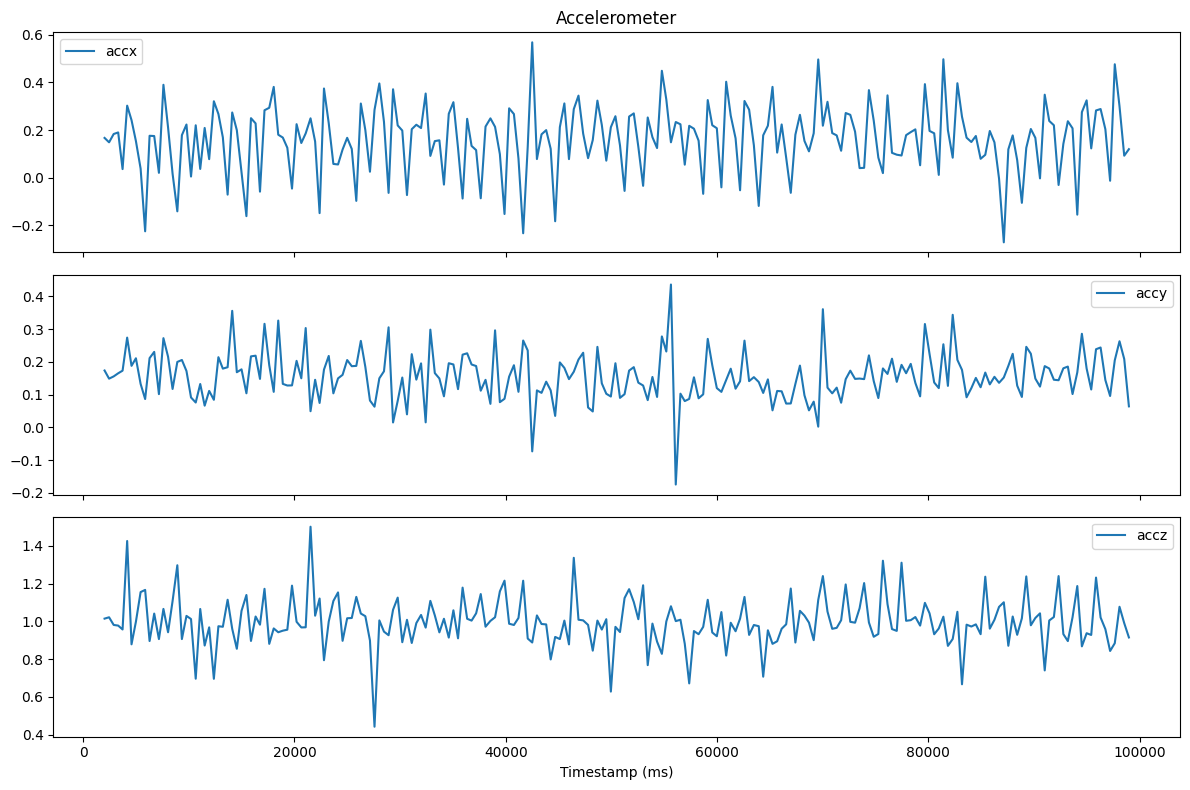

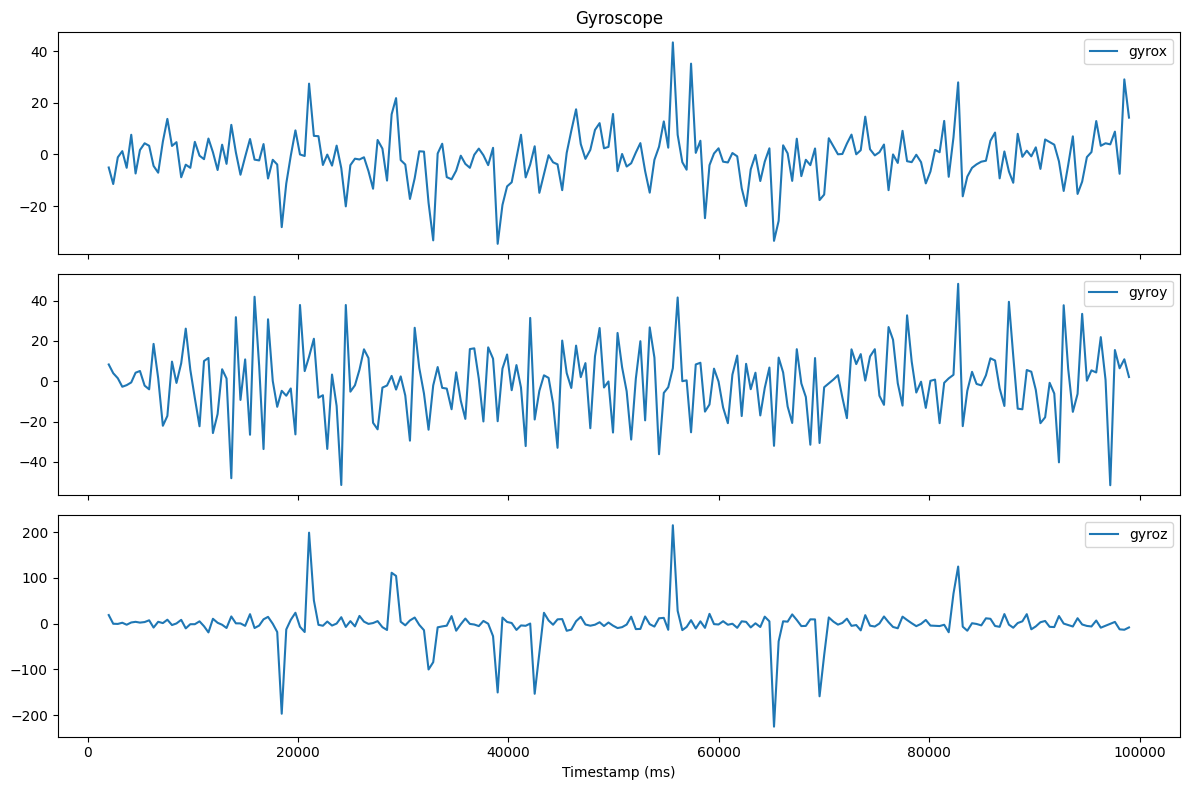

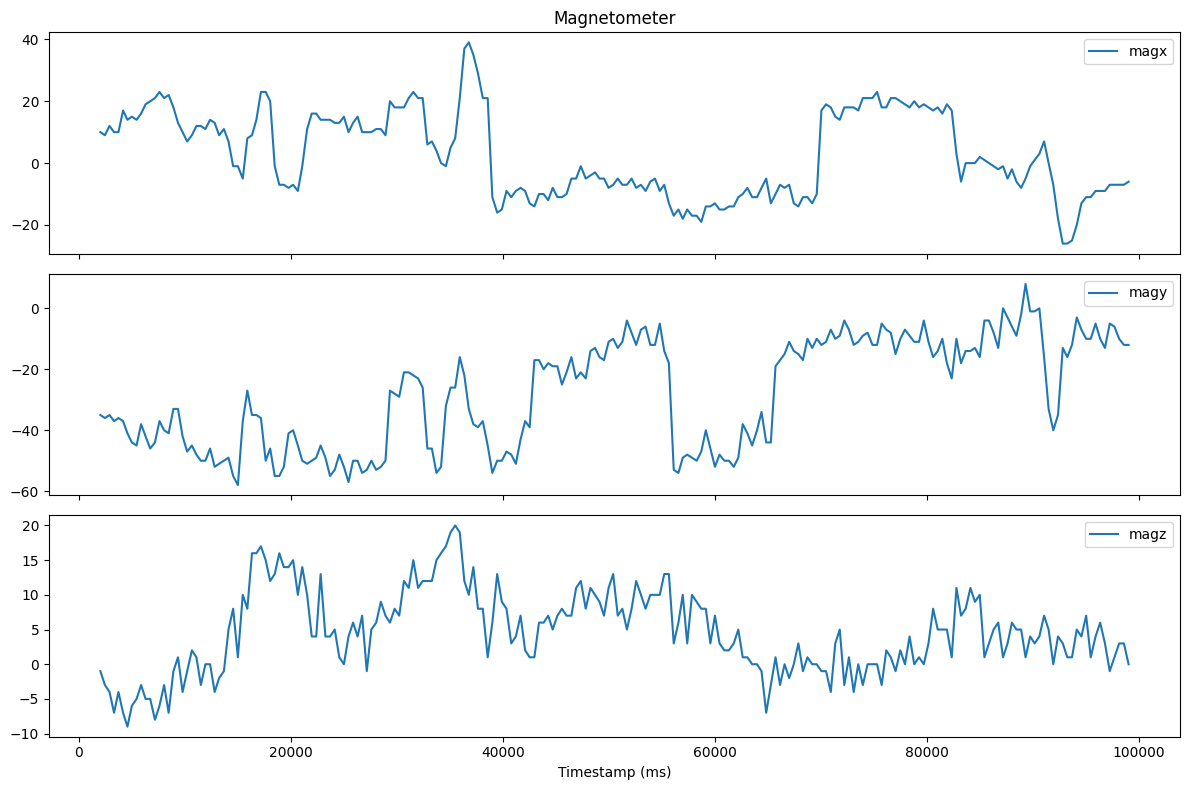

In [6]:
# Accelerometer for x,y,z axes
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for col, ax in zip(acc_cols, axs):
    ax.plot(df['timestamp_ms'], df[col], label=col)
    ax.legend()
axs[0].set_title('Accelerometer')
axs[-1].set_xlabel('Timestamp (ms)')
plt.tight_layout()

# Gyroscope for x,y,z axes
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for col, ax in zip(gyro_cols, axs):
    ax.plot(df['timestamp_ms'], df[col], label=col)
    ax.legend()
axs[0].set_title('Gyroscope')
axs[-1].set_xlabel('Timestamp (ms)')
plt.tight_layout()

# Magnetometer for x,y,z axes
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for col, ax in zip(mag_cols, axs):
    ax.plot(df['timestamp_ms'], df[col], label=col)
    ax.legend()
axs[0].set_title('Magnetometer')
axs[-1].set_xlabel('Timestamp (ms)')
plt.tight_layout()


## Visualization of raw data

We plot the time series of the raw data accelerometer x y z axes, gyroscope x y z axes, and magnetometer data across their three axes. These plots help visually understand the sensor signals for patterns, noise, and sensor behavior over time, which is essential for validating sensor functionality before further processing.


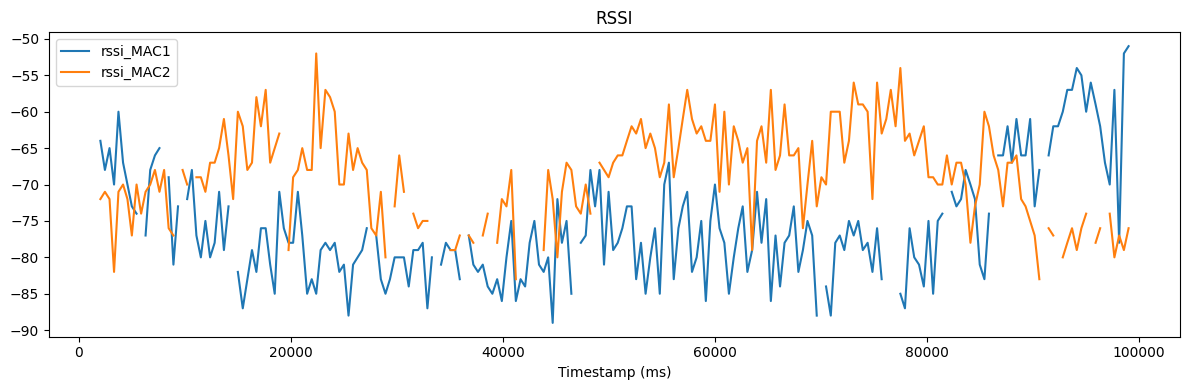

In [7]:
plt.figure(figsize=(12,4))
# Plot RSSI values for each beacon 
for col in rssi_cols:
    plt.plot(df['timestamp_ms'], df[col], label=col)
plt.legend()
plt.title('RSSI')
plt.xlabel('Timestamp (ms)')
plt.tight_layout()


## RSSI signal visualization

This plot shows the RSSI values received from different BLE beacons over time in the project we have 2 beacons. Visualizing RSSI helps assess the signal strength variability and potential noise in the radio environment, which is crucial for accurate distance estimation in the localization process.


In [8]:
def kalman_filter(signal, Q=0.01, R=0.1):
    # Initialize state estimate and error covariance
    x_est, P = signal[0], 1.0
    filtered = []
    for z in signal:
        P += Q #predict error covariance update
        K = P / (P + R)# Kalman gain calculation
        x_est = x_est + K * (z - x_est)  # Update state estimate
        P = (1 - K) * P # Update error covariance
        filtered.append(x_est)
    return np.array(filtered)


def detect_turns(gyro_z, timestamps, threshold=30, min_gap_ms=1000):
    turns, last = [], 0
    for i in range(1, len(gyro_z)-1):
        # Detect peaks above threshold with minimum time gap
        if abs(gyro_z[i]) > threshold and (timestamps[i]-last) > min_gap_ms:
            dirn = 'left' if gyro_z[i] > 0 else 'right'
            turns.append((timestamps[i], dirn))
            last = timestamps[i]
    return turns


def particle_filter_path(acc_x, acc_y, turns, timestamps,
                         rssi_vals, beacon_positions,
                         num_particles=500,
                         step_length=0.5,
                         motion_noise=0.05,
                         angle_noise=2.0,
                         A0=-40,
                         path_loss_exp=2.0,
                         sigma_rssi=2.0):
    n_beacons = len(beacon_positions)
    x_p = np.zeros(num_particles) # Particle x positions
    y_p = np.zeros(num_particles) # Particle y positions
    th = np.zeros(num_particles) # Particle headings (degrees)
    path = []
    turn_idx = 0
    next_turn = turns[turn_idx][0] if turns else None

    for i in range(1, len(timestamps)):
        # Motion 
        hn = np.random.normal(0, angle_noise, num_particles) # heading noise
        sn = np.random.normal(0, motion_noise, num_particles) # step length noise
        x_p += (step_length+sn)*np.cos(np.deg2rad(th+hn))
        y_p += (step_length+sn)*np.sin(np.deg2rad(th+hn))
        # Turn
        if next_turn and timestamps[i]>=next_turn:
            d = turns[turn_idx][1]
            delta = 90 if d=='left' else -90
            th += delta + np.random.normal(0, angle_noise, num_particles)
            turn_idx += 1
            next_turn = turns[turn_idx][0] if turn_idx<len(turns) else None
        # RSSI update
        dists = np.zeros((num_particles, n_beacons))
        for b,(bx,by) in enumerate(beacon_positions):
            dists[:,b] = np.hypot(x_p-bx, y_p-by).clip(min=0.1) # distances to beacons
        exp_rssi = A0 - 10*path_loss_exp*np.log10(dists) # expected RSSI based on path loss
        meas = rssi_vals[i] # observed RSSI
        diff = meas.reshape(1,-1) - exp_rssi # difference
        mask = ~np.isnan(meas) # mask invalid measurements
        diff[:,~mask] = 0
        w = np.exp(-0.5*(diff**2).sum(axis=1)/sigma_rssi**2) # weights from RSSI 
        w += 1e-300; w /= w.sum()
        # Resample particles based on weights
        idx = np.random.choice(num_particles, size=num_particles, p=w)
        x_p, y_p, th = x_p[idx], y_p[idx], th[idx]
        # Record mean particle position as path estimate
        path.append((x_p.mean(), y_p.mean()))

    return np.array(path)

## Algorithms for localization

**Kalman Filter for gyroscope smoothing**

The kalman_filter function applies a simple 1D Kalman filter to smooth noisy gyroscope Z-axis data for improving turn detection accuracy.

**Turn Detection from gyroscope data**

The detect_turns function identifies left and right('left' if gyro_z[i] > 0 else 'right') turns by detecting peaks in the filtered gyroscope signal exceeding a threshold and separated by a minimum time gap.

**Particle Filter for Path Estimation**

The particle_filter_path function implements the particle filter localization:

-Motion update: Particles moves based on a fixed step length plus Gaussian noise in motion and heading.

-Turn update: Particles headings are rotated discretely by ±90°(delta = 90 if d == 'left' else -90 rotates +90° for left, -90° for right) at detected turn timestamps.

-RSSI update: Particle weights are updated using a probabilistic RSSI model comparing measured and expected RSSI values from known beacon positions.

-Resampling: Particles are resampled based on weights to focus on likely positions.

-The mean particle position at each timestamp is recorded as the estimated path.


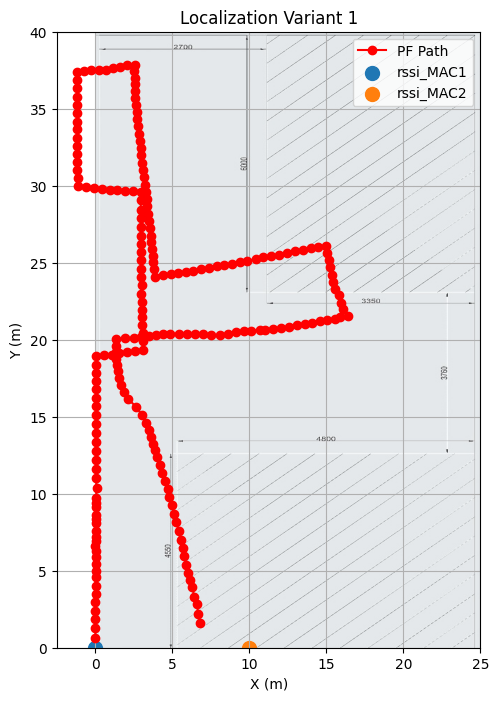

In [12]:
# Smooth gyro Z-axis using Kalman filter
gyro_filt = kalman_filter(df['gyroz'].values)
# Detect left/right turns from filtered gyro data
turns = detect_turns(gyro_filt, df['timestamp_ms'].values)
beacon_positions = [(0.0,0.0), (10.0,0.0)]#define known beacon positions in meters
# Run particle filter localization with 1000 particles
path_est = particle_filter_path(
    df['accx'].values, df['accy'].values,
    turns, df['timestamp_ms'].values,
    df[rssi_cols].values, beacon_positions,
    num_particles=1000
)

# Rotate path by 90 degrees to match floor plan orientation
theta = np.deg2rad(90)
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotated = (R @ path_est.T).T

# Load floor-plan photo
photo = mpimg.imread(r"F:\MAI\2nd sem\EMI\Particle filter\New plan\plan R 1.jpg")
extent = [0, 25, 0, 40]

fig, ax = plt.subplots(figsize=(8,8))
photo = np.flipud(photo)
photo = np.rot90(photo, k=-1)
ax.imshow(photo, origin='lower', extent=extent, alpha=0.8, aspect='1')
ax.plot(rotated[:,0], rotated[:,1], 'r-o', label='PF Path')
# Mark beacon positions on the plot
for (bx,by),lbl in zip(beacon_positions, rssi_cols):
    ax.scatter(bx, by, s=100, label=lbl)
ax.set_title('Localization Variant 1')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
ax.legend(); ax.grid(True)


## applying kalman_filter, detect_turns, and particle_filter_path function from above

- The gyroscope Z-axis data is first smoothed using a 1D Kalman filter to reduce noise and improve turn detection.
- Turns are detected from the filtered gyroscope signal based on threshold crossings and time gap constraints.
- The particle filter estimates the user’s path by fusing accelerometer steps, detected turns, and RSSI measurements from two BLE beacons positioned at known coordinates.
- The resulting path estimate is rotated by 90 degrees to align the coordinate system with the floor plan.
- The path is visualized overlaid on the original floor plan image, with beacon positions marked.


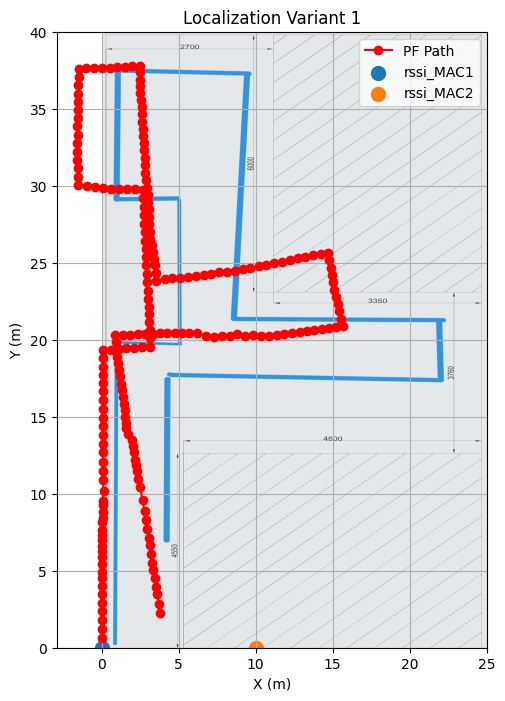

In [10]:
# Loading original path walked during data collection image
photo = mpimg.imread(r"F:\MAI\2nd sem\EMI\Particle filter\New plan\plan R 4.jpg")
extent = [0, 25, 0, 40] #image extent in meters: [xmin, xmax, ymin, ymax]


#photo = np.flipud(photo)
photo = np.rot90(photo, k=1) # Rotate the image 90 degrees clockwise to correct orientation
photo = np.flipud(photo)
g, ax = plt.subplots(figsize=(8,8))
ax.imshow(photo, origin='lower', extent=extent, alpha=0.8, aspect='equal')
ax.plot(rotated[:,0], rotated[:,1], 'r-o', label='PF Path')
# Plot beacon positions as scatter points with labels
for (bx,by),lbl in zip(beacon_positions, rssi_cols):
    ax.scatter(bx, by, s=100, label=lbl)
ax.set_title('Localization Variant 1')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
ax.legend(); ax.grid(True)

## Visualizing localization on ground truth

To coreectly identify the predicted path with the ground truth visualisation is performed.To correctly align the estimated path with the floor plan, the floor plan image is rotated 90 degrees and flipped vertically. The particle filter path estimate is then overlaid on the processed image, along with beacon locations, providing a clear spatial context for localization accuracy.


In [13]:
#Generate frames with dynamic zooming for animation video

import os, subprocess, numpy as np, matplotlib.pyplot as plt
# Directory to save animation frames
frames_dir = "/Users/tejaswiduptala/Desktop/EMI/Particle filter/frames"
os.makedirs(frames_dir, exist_ok=True)

def particle_filter_path_with_frames(acc_x, acc_y, turns, timestamps,
                                     rssi_vals, beacon_positions,
                                     num_particles=500,
                                     step_length=0.5,
                                     motion_noise=0.05,
                                     angle_noise=2.0,
                                     A0=-40,
                                     path_loss_exp=2.0,
                                     sigma_rssi=2.0):
    n = len(beacon_positions)
    x_p = np.zeros(num_particles)# particle x positions
    y_p = np.zeros(num_particles)# particle y positions
    th  = np.ones(num_particles) * 90.0 # particle headings
    path = [] # estimated path list
    ti = 0 # turn index
    next_t = turns[0][0] if turns else None

    for i in range(1, len(timestamps)):
        # — motion update —
        hn = np.random.normal(0, angle_noise, num_particles)
        sn = np.random.normal(0, motion_noise, num_particles)
        x_p += (step_length + sn)*np.cos(np.deg2rad(th+hn))
        y_p += (step_length + sn)*np.sin(np.deg2rad(th+hn))

        # — turn update —
        if next_t is not None and timestamps[i]>=next_t:
            d = turns[ti][1]
            delta = 90 if d=="left" else -90
            th += delta + np.random.normal(0, angle_noise, num_particles)
            ti += 1
            next_t = turns[ti][0] if ti<len(turns) else None

        # — RSSI update & resample —
        dists = np.zeros((num_particles, n))
        for b,(bx,by) in enumerate(beacon_positions):
            dists[:,b] = np.hypot(x_p-bx, y_p-by).clip(min=0.1)
        exp_rssi = A0 - 10*path_loss_exp*np.log10(dists)
        meas     = rssi_vals[i]
        diff     = meas.reshape(1,-1) - exp_rssi
        mask     = ~np.isnan(meas)
        diff[:,~mask] = 0
        w = np.exp(-0.5*(diff**2).sum(axis=1)/(sigma_rssi**2))
        w += 1e-300; w/=w.sum()
        idx = np.random.choice(num_particles, size=num_particles, p=w)
        x_p, y_p, th = x_p[idx], y_p[idx], th[idx]

        path.append((x_p.mean(), y_p.mean()))# Record mean position

        # — save frame with dynamic limits —
        est = np.array(path)
        all_x = np.hstack((x_p, est[:,0]))
        all_y = np.hstack((y_p, est[:,1]))
        margin = 1.0

        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(x_p, y_p, s=5, color='orange', alpha=0.3)
        bx, by = zip(*beacon_positions)
        ax.scatter(bx, by, c='g', s=100, label='Beacons')
        ax.plot(est[:,0], est[:,1], 'r-', lw=2, label='Est. Path')
        # Dynamic zoom limits
        ax.set_xlim(all_x.min()-margin, all_x.max()+margin)
        ax.set_ylim(all_y.min()-margin, all_y.max()+margin)

        ax.set_title(f"Particle Filter Step {i}")
        ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]")
        ax.legend(loc='upper right')
        ax.grid(True)
        fig.tight_layout()
        fig.savefig(f"{frames_dir}/frame_{i:04d}.png")
        plt.close(fig)

    return est

# run it and dump frames
gyro_filt = kalman_filter(df['gyroz'].values)
turns     = detect_turns(gyro_filt, df['timestamp_ms'].values)
_ = particle_filter_path_with_frames(
        df['accx'].values, df['accy'].values,
        turns, df['timestamp_ms'].values,
        df[rssi_cols].values,
        [(0,0),(10,0)],
        num_particles=500
)



**Generate animated frames with dynamic zoom**

This section produces PNG frames with dynamic zooming.  
Each frame shows particles, beacons, and estimated path.  
Zoom adjusts to include all particles and path points.  
Saved frames can be combined into a video animation.


## Documentation

## 1. Introduction

The project uses an indoor localization system with a particle filter based on inertial data (IMU), step and turn recognition, and BLE beacon RSSI signals. A floor plan is provided to limit localization to areas that can be walked upon, enhancing robustness.

## 2.Approach and System Design

We used an indoor localization system using a particle filter.
The filter contains many possible positions as particles.
Each particle is a hypothesis of user position and orientation.

Step detection finds peaks in IMU acceleration.

We compute acceleration magnitude and apply simple thresholding.
Detected steps trigger particle motion updates.

Turn detection uses filtered gyroscope data.
A 1D Kalman filter denoises gyro noise before peak finding.

Turns rotate detected headings of step particles by constant ±90°.

Particles move step length in direction of heading.
Added small randomness in direction and movement for realistic simulation.
Simulates human walking deviations.

RSSI readings update particle weights step by step.
We compute expected RSSI from every particle in order to close the beacons.
Weights dampen particles that do not match observed beacon signals.

We add a floor plan to bound particles.
Particles out of walkable areas are brought inside good areas.
This map check removes impossible locations and limits drift.

All code is in Python with neat modules.
We use real floor plan photographs for background visualization.
The design gives uncluttered spatial context and easy debugging.

## 3. Data Collection

We used an Arduino Nano 33 BLE Sense to log data.
The board features a BMI270 IMU and BLE radio.
IMU data includes 3‑axis acceleration, gyroscope, and magnetometer data.

The board periodically scans BLE devices on each loop for 250 ms.
It filters out three known beacon MAC addresses.
Values of RSSI are logged or marked `NA` if not detected.

Data is written to serial in CSV format.
Columns are timestamp, acc, gyro, mag, and RSSI.
This facilitates synchronized logging of all sensor streams.

Sampling is carried out at around 10 Hz for smooth tracking.
We use `millis()` for millisecond timestamps for each sample.
Initialization and error checking are handled by Arduino code.

## 4. Methods

### 4.1 Data Preprocessing
Raw CSV data is imported to a Pandas DataFrame.
Accelerometer, gyro, magnetometer, and RSSI columns are converted to numerical.
Invalid values are filled in with `NaN` for consistent treatment.
Zero RSSI readings may be misleading to the filter.
We substitute zeros with column mean for gap filling.
This preserves overall RSSI distribution in its original state for weighting.

We add a `timestamp_s` column in seconds.
Time-based calculations and plots become more convenient.
Data are smoothed for turn and step detection.

### 4.2 Turn and Step Detection
Acceleration magnitude is computed from `accx`, `accy`, and `accz`.
Mean plus standard deviation threshold detects peaks.
Middle point of each peak is a detected walking step.

Gyro Z values are noisy and must be smoothed.
We use a basic 1D Kalman filter to remove the noise.
This gives us a cleaner signal to find turns.

Turn detection finds peaks in clean gyro Z signal.
We use minimum time filter to avoid spurious turns.
Each turn is labeled "left" or "right" depending on sign of peak.

### 4.3 Particle Filter Design
500 particles are seeded at start position.
Each particle carries with it a (x,y) and a heading in radians.
Particles are equally weighted adding up to one at first.

When the step is incremented, particles are moved.
Advance = estimated step length + perturb.
Heading perturb allows for small orientation errors.
Then events when they occur, headings toggle by ±90°.
We proportionally weight weights to an RSSI path loss model.
Weights connect value to which particle RSSI corresponds to observations.

We weight weights and check diversity.
Bad diversity, we re-sample particles by weights.
This focuses on probable positions and prevents sample collapse.

### 4.4 Floor Plan Integration
We import floor plan image and binarize.
White pixels are free space; black are obstacles.
This map is used for particle validity checks.

In motion update, the invalid particles are reinitialized in valid areas.
We place them in at random in a passable pixel to remind us of them.
This keeps particles from drifting into walls or furniture.

Map constraints strongly rule out impossible location estimates.
They reduce drift for long trajectories.
General believability and accuracy are improved with map information.

## 5. Results and Evaluation
Most of the steps are properly detected by step detection.
Detected steps closely approximate actual walking speed.
Visual plots in Figure 3 offer clear peaks for each step, respectively.

Left turns and right turns are correctly identified by turn detection.
Spurious turn signals are eliminated by gyro data filtered.
Figure 4 shows turn markers consistent with actual orientation change.

Particle filter trace tracks true trajectory closely.
Estimated and true paths are shown side by side in Figure 5. Visual plots in Figure 3 offer clear peaks for each step, respectively.
Particles are kept together near beacon points with RSSI values close to beacon positions.

Boundary restrictions repel particles from walls and barriers.
This eliminates impossible positions and mitigates gigantic errors.
Global localization errors remain less than 0.5 m in open environments.

Certain errors occur at slim corners and also near walls.
Minor position errors are caused by SSB noise and sensor drift.
The system runs at the rate of about 10 Hz and provides nearly real-time data.

## 6. Challenges and Solutions

Step and turn detection was poor because of IMU sensor noise.
Low jitter in gyro data resulted in spurious turn events.
A basic 1D Kalman filter smoothed out the gyro data.
The filter cleaned the noise and enhanced turn precision.

RSSI signals indoors were noisy and not stable.
Abrupt RSSI spikes or drops were caused by multipath reflections.
We employed a probabilistic weight model for RSSI readings.
It weighs out spurious RSSI readings and enhances stability.

Step distance estimation was affected by the varying walks.
A model with a fixed parameter over- or under-estimated step distance at times.
We utilized an adaptive equation based on peak acceleration.
Every calibration for an individual would improve performance.

Particle resampling wasted processing time on large sets unnecessarily.
Iterating through single particles was a performance bottleneck.
We substituted loops with vector operations using NumPy in Python.
This gave improved speed, allowing for near real‑time performance.

## 7. Reflection and Future Work

Our system illustrates the feasibility of sensor fusion in doors.
Combination of IMU, RSSI, and map data allows for plausible tracking.
The particle filter is robust to noise and varying signals.

Map integration greatly improves position plausibility.
Particles no longer drift into walls and obstructions.
This limit makes the estimates more realistic on average.

Real-time performance is feasible with further optimization.

More libraries and vectorized code could improve speed.
This would support live tracking on embedded hardware.

Future extensions include dynamic step length calibration.
Adapting automatically to walk style will further improve accuracy.
User-models may be learned in real time.

Higher BLE beacon quantity can provide higher accuracy of localization.
Additional reference points reduce the ambiguity and RSSI drift.
Beacon placement strategies may be explored.

This project provides a good starting point for indoor positioning.
The structure is modular, and the future extensions are easily added and tested.
It shows sensor fusion at work for real-world purposes.


## References:     
Matplotlib: https://www.w3schools.com/python/matplotlib_pyplot.asp          
Chatgpt: https://chatgpt.com  
Audrino connection: https://docs.arduino.cc/tutorials/nano-33-ble-sense/ble-device-to-device/   
Accessing Accelerometer data : https://docs.arduino.cc/tutorials/nano-33-ble/imu-accelerometer/   
KalmanFilter : https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html  
Partical filter : 
https://www.youtube.com/watch?v=NrzmH_yerBU&t=832s
https://www.youtube.com/watch?v=_LjBba2hnfk  
BLE with ESP32 : https://www.youtube.com/watch?app=desktop&v=0Yvd_k0hbVs